### Importing Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import cv2
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models import resnet18, efficientnet_b0, mobilenet_v2, efficientnet_v2_s
from sklearn.metrics import f1_score

from albumentations import Compose, Normalize, Resize
from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
SEED= 42
np.random.seed(SEED)
torch.manual_seed(SEED)
plt.ion()

In [4]:
repository_root = Path.cwd().parent.parent.parent.parent

root_dir = repository_root / "myanmar-weather-forecasting" / "data" / "traffic" / "singapore-traffic-density"

save_dir= repository_root / "myanmar-weather-forecasting" / "src" / "traffic" / "models" / "models_runs"


configs

In [5]:
Res18_config= {'network': 'resnet18', 'in_channels': 224, 'num_classes': 5} 
ENb0_config= {'network': 'efficientnet-b0', 'in_channels': 224, 'num_classes': 5}
MNv2_config= {'network': 'mobilenet_v2', 'in_channels': 224, 'num_classes': 5}
ENv2_config= {'network': 'efficientnet_v2_s', 'in_channels': 224, 'num_classes': 5}

# NUM_WORKERS = 0 > https://github.com/pytorch/pytorch/issues/13246
training_config= {'BATCH_SIZE': 64, 'NUM_WORKERS': 0, 'WARM_UP_EPOCHS': 10, 'WARM_UP_LR': 1e-4, 
                  'FINE_TUNE_EPOCHS': 100, 'FINE_TUNE_LR': 1e-6}

### showing some insights

In [6]:
# utils functions for visualization
def load_image(img_path: Path):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(np.array(images))
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11).cpu() # if not on GPU remove .cpu()
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [7]:
examples= root_dir/"train"/"High"

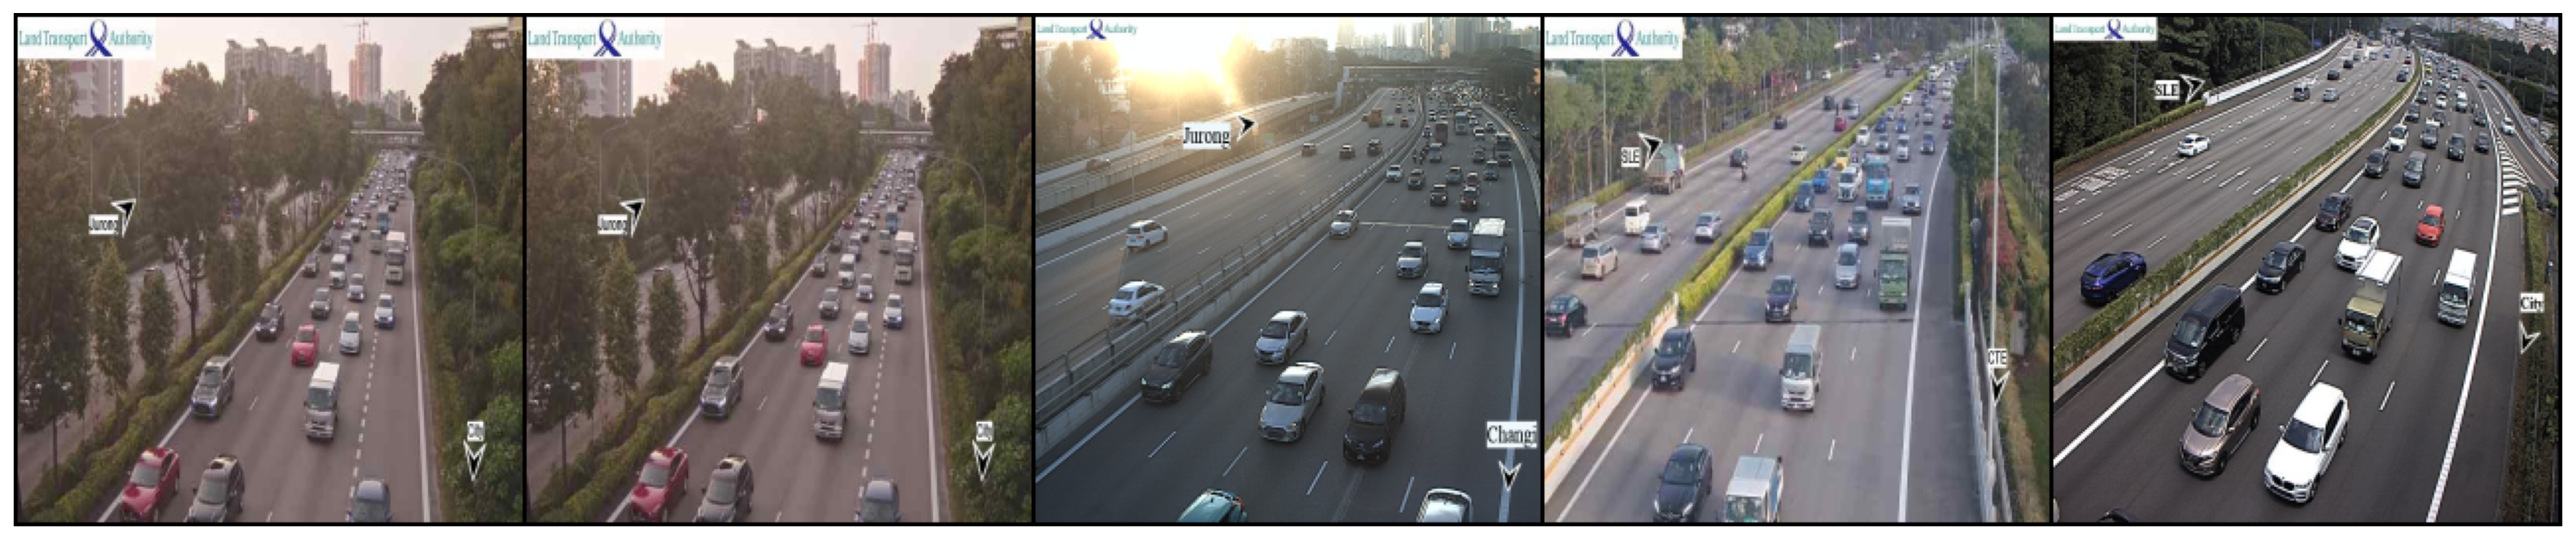

In [8]:
img_paths = list(Path(examples).glob("*.jpg"))[:5]
show_grid(img_paths)

In [11]:
df= pd.read_csv(root_dir/"singapore-traffic-density.csv")

In [12]:
# windows need full path, might be modified later, even better use ImageFolder
df.img_path= df.img_path.apply(lambda x: os.path.join(repository_root, x))

In [13]:
# a bit of imbalence here
df[df['split']=='train'].groupby(['label']).count()

img_path  split
label                       
Empty            1186   1186
High              378    378
Low               936    936
Medium            688    688
Traffic Jam       190    190

In [14]:
df[df['split']=='val'].groupby(['label']).count()

img_path  split
label                       
Empty              64     64
High               64     64
Low                64     64
Medium             64     64
Traffic Jam        64     64

In [15]:
df[df['split']=='test'].groupby(['label']).count()


img_path  split
label                       
Empty             120    120
High               38     38
Low                94     94
Medium             70     70
Traffic Jam        18     18

### building dataset

In [16]:
class TrafficDataset(Dataset):
    def __init__(self, df, preprocess=None):
        self.img_dirs = df.img_path.to_numpy()
        self.label = df.label.to_numpy()
        self.classes, self.label_encoder= self.process_label(df)
        self.preprocess = preprocess

    def __len__(self):
        return len(self.img_dirs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx= idx.tolist()

        img_path= self.img_dirs[idx]
        label= self.label[idx]

        img= cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.preprocess is not None:
            img = self.preprocess(image=img)

        return {
            'img': img,
            'label': torch.tensor(self.label_encoder[label], dtype=torch.long)
        }
    
    def process_label(self, df):
        classes= df.label.unique().tolist()
        label_encoder= {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, label_encoder
        

In [17]:
# a lot of improvements can be made here
preprocess= Compose([
    Resize(224, 224),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1)
])

In [18]:
df_train = df[df['split'] == 'train']
df_val = df[df['split'] == 'val']
df_test = df[df['split'] == 'test']

In [19]:
train_dataset = TrafficDataset(
    df=df_train,
    preprocess=preprocess
)
val_dataset = TrafficDataset(
    df=df_val,
    preprocess=preprocess
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=True,
    num_workers=training_config['NUM_WORKERS'],
    generator=torch.Generator(device='cuda')
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=False,
    num_workers=training_config['NUM_WORKERS'],
    generator=torch.Generator(device='cuda')
)
test_dataset = TrafficDataset(
    df=df_test,
    preprocess=preprocess
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=training_config['BATCH_SIZE'], # feel free to set it to 1 if used for inference
    shuffle=False,
    num_workers=training_config['NUM_WORKERS'],
    generator=torch.Generator(device='cuda')
)

In [20]:
# everything worked properly 
for batch in tqdm(train_dataloader):
    img_batch = batch['img']['image']
    label_batch = batch['label']

    print(type(img_batch), img_batch.shape)
    print(type(label_batch), label_batch.shape)

    break

  0%|          | 0/53 [00:00<?, ?it/s]

<class 'torch.Tensor'> torch.Size([64, 224, 224, 3])
<class 'torch.Tensor'> torch.Size([64])


### Training Utils

In [23]:
# def calculate_f1(preds, labels, THRESHOLD = 0.5, EPSILON = 1e-7):

#     labels = np.array(labels, dtype=np.uint8)
#     preds = (np.array(preds) >= THRESHOLD).astype(np.uint8)
#     tp = np.count_nonzero(np.logical_and(labels, preds))
#     tn = np.count_nonzero(np.logical_not(np.logical_or(labels, preds)))
#     fp = np.count_nonzero(np.logical_not(labels)) - tn
#     fn = np.count_nonzero(labels) - tp
#     precision = tp / (tp + fp + EPSILON)
#     recall = tp / (tp + fn + EPSILON)
#     f1 = (2 * precision * recall) / (precision + recall + EPSILON)
    
#     return f1

def calculate_f1(y_true, y_pred, average='macro'):
    return f1_score(y_true, y_pred, average=average)

In [24]:
class FocalLoss(nn.Module):
    """
    focal loss implementation by: https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
    this loss is good with class imbalance, although cross entropy almost has the same effect as focal loss in this dataset
    """
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

### Building Model

In [21]:
# we need to modify the input (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
# and output layers (fc): Linear(in_features=512, out_features=1000, bias=True)
# same goes for the other models

resnet18(pretrained=True)

c:\Users\AmrEl\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AmrEl\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def TrafficClassifier(cfg, load_path=None):
    if load_path:
        try:
            print('[*] Attempting to load model from:', load_path)
            model = _TrafficClassifier(cfg)
            model.load_state_dict(torch.load(load_path)['state_dict'])
        except: 
            print('[*] Model does not exist or is corrupted. Creating new model...')
            return _TrafficClassifier(cfg)

        # check whether `model` is an _TrafficClassifier instance
        if model.__class__.__name__ == '_TrafficClassifier':
            return model
        else:
            raise ValueError('The loaded tensor is not an instance of _TrafficClassifier.')
    else:
        print('[*] Creating model...')
        return _TrafficClassifier(cfg)

class _TrafficClassifier(nn.Module):
    def __init__(self, cfg):
        super(_TrafficClassifier, self).__init__()
        self.num_classes= cfg['num_classes']
        self.in_channels= cfg['in_channels']
        self.network= cfg['network']

        if cfg['network'] == "resnet18":
           self.initialize_resnet18()

        if cfg['network'] == "efficientnet-b0":
            self.initialize_enb0()
        
        if cfg['network'] == "mobilenet_v2":
            self.initialize_mnv2()

        if cfg['network'] == "efficientnet_v2_s":
            self.initialize_en_v2()

    def forward(self, x):
        return self.encoder(x)
    
    def freeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def freeze_middle_layers(self):
        self.freeze_all_layers()
        if self.network == "resnet18":
            for param in self.encoder.conv1.parameters():
                param.requires_grad = True
                
            for param in self.encoder.fc.parameters():
                param.requires_grad = True

        elif self.network == "efficientnet-b0" or self.network == "mobilenet_v2" or self.network == "efficientnet_v2_s":
            for param in self.encoder.features[0][0].parameters():
                param.requires_grad = True

            for param in self.encoder.classifier.parameters():
                param.requires_grad = True

        else:
            raise ValueError("Something went wrong! Model is not defined")

    def unfreeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

    def initialize_resnet18(self):
        print('[*] Initializing new resnet18 network...')
        # we need to modify the input (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
        # and output layers (fc): Linear(in_features=512, out_features=1000, bias=True)
        self.encoder = resnet18(pretrained=True).to(device)

        # modifying input layer.
        self.encoder.conv1 = nn.Conv2d(
            self.in_channels,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        
        # modifying output layer.
        self.encoder.fc = nn.Linear(512, self.num_classes, bias= True)

    def initialize_enb0(self):
        print('[*] Initializing new efficientnet-b0 network...')
        self.encoder = efficientnet_b0(pretrained=True).to(device)
        
        self.encoder.features[0][0] = nn.Conv2d(
            self.in_channels,
            32,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        )

        self.encoder.classifier[1]= nn.Linear(1280, self.num_classes, bias= True)

    def initialize_mnv2(self):
        print('[*] Initializing new mobilenet_v2 network...')
        self.encoder = mobilenet_v2(pretrained=True).to(device)
        
        self.encoder.features[0][0] = nn.Conv2d(
            self.in_channels,
            32,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        )

        self.encoder.classifier[1]= nn.Linear(1280, self.num_classes, bias= True)

    def initialize_en_v2(self):
        print('[*] Initializing new efficientnet-v2 network...')
        self.encoder = efficientnet_v2_s(pretrained=True).to(device)
        
        self.encoder.features[0][0] = nn.Conv2d(
            self.in_channels,
            24,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        )

        self.encoder.classifier[1]= nn.Linear(1280, self.num_classes, bias= True)
  
    def _get_index_of_matched_value(self, dictionary, value):

        for idx, val in dictionary.items():
            if val == value:
                return idx

        return None
    
    def test_model(self, test_loader):
        self.eval()
        criterion= FocalLoss()
        with torch.no_grad():            
            test_batch_losses = []
            test_pbar = tqdm(test_loader)
            test_pbar.desc = 'Testing'

            all_labels = []
            all_preds = []
            all_out= []

            for i_batch, sample_batched in enumerate(test_pbar):
                # Make prediction.
                y_pred = self.encoder(sample_batched['img']['image'])
                out= torch.argmax(y_pred, dim= 1)

                
                all_labels.extend(sample_batched['label'].tolist())
                all_preds.extend(y_pred.cpu().detach().numpy().tolist()) # batch x number_of_cls
                all_out.extend(out.tolist())

                # Compute val loss.
                test_loss = criterion(y_pred, sample_batched['label'].view(-1, 1))
                test_batch_losses.append(test_loss.item())

                # Display some information in progress-bar.
                test_pbar.set_postfix({
                    'test_loss': test_batch_losses[-1]
                })

            test_loglosses = criterion(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
            test_f1_scores = calculate_f1(all_out, all_labels)

            test_losses = np.array(test_batch_losses).mean()
        
        return test_loglosses, test_f1_scores, test_losses

    def inference(self, img_path):
        self.eval()
        img= cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img= preprocess(image= img) # resizing is important
        _img= np.expand_dims(img['image'], axis= 0)
        _img= torch.tensor(_img)
        _img.to(device)
        with torch.no_grad():
            y_pred = self.encoder(_img)
            out= torch.argmax(y_pred, dim= 1)
            
        output= self._get_index_of_matched_value(train_dataset.label_encoder, out)
        return output
        


### Modeling

In [23]:
class TrafficTrainer:
    def __init__(self, 
                 model_conf, 
                 train_dataloader,
                 val_dataloader,
                 cfg,
                 save_dir,
                 best_val_loss= 1e7,
                 best_val_logloss= 1e7,
                 save_the_best_on= 'val_logloss'):
        
        self.model_conf= model_conf
        self.model= TrafficClassifier(model_conf)
        self.cfg= cfg
        self.save_dir= save_dir
        self.model_path= os.path.join(self.save_dir, model_conf['network'])
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
        self.train_dataloader= train_dataloader
        self.val_dataloader= val_dataloader
        self.best_val_loss= best_val_loss
        self.best_val_logloss= best_val_logloss
        self.save_the_best_on= save_the_best_on
        self.losses = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.val_losses = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.loglosses = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.val_loglosses = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.f1_scores = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.val_f1_scores = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])


    def _call(self):

        losses = np.zeros(self.epochs)
        val_losses = np.zeros(self.epochs)
        loglosses = np.zeros(self.epochs)
        val_loglosses = np.zeros(self.epochs)
        f1_scores = np.zeros(self.epochs)
        val_f1_scores = np.zeros(self.epochs)
        best_model_state_dict = None
        best_optimizer_state_dict = None

        criterion = FocalLoss().to(device)
        logloss = nn.CrossEntropyLoss().to(device)

        for i in tqdm(range(self.epochs)):
            batch_losses = []
            val_batch_losses = []

            all_train_labels = []
            all_val_labels = []
            all_train_preds = []
            all_val_preds = []
            all_train_out= []
            all_val_out= []

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    pbar = tqdm(train_dataloader)
                    pbar.desc = f'Epoch {i+1}'
                else:
                    pbar = tqdm(val_dataloader)
                    pbar.desc = 'Validating'
                    self.model.eval()

                for i_batch, sample_batched in enumerate(pbar):
                    inputs= sample_batched['img']['image'].to(device)
                    labels= sample_batched['label'].to(device)

                    self.optimizer.zero_grad()
                    # Make prediction.
                    with torch.set_grad_enabled(phase == 'train'):
                        y_pred = self.model(inputs)
                        out= torch.argmax(y_pred, dim= 1)


                        # Compute loss.
                        loss = criterion(y_pred, labels)

                        if phase == 'train':
                            batch_losses.append(loss.item())
                            # Zero gradients, perform a backward pass, and update the weights.
                            loss.backward()
                            self.optimizer.step()

                        else:
                            val_batch_losses.append(loss.item())



                    # Display some information in progress-bar.
                    if phase == 'train':
                        all_train_labels.extend(sample_batched['label'].tolist())
                        all_train_preds.extend(y_pred.cpu().detach().numpy().tolist())
                        all_train_out.extend(out.tolist())
                        pbar.set_postfix({
                            'loss': batch_losses[-1]
                        })
                    else:
                        all_val_labels.extend(sample_batched['label'].tolist())
                        all_val_preds.extend(y_pred.cpu().detach().numpy().tolist())
                        all_val_out.extend(out.tolist())
                        pbar.set_postfix({
                            'val_loss': val_batch_losses[-1]
                        })

            # Compute scores.
            loglosses[i] = logloss(torch.tensor(all_train_preds).to(device), torch.tensor(all_train_labels).to(device))
            f1_scores[i] = calculate_f1(all_train_out, all_train_labels)
            val_loglosses[i] = logloss(torch.tensor(all_val_preds).to(device), torch.tensor(all_val_labels).to(device))
            val_f1_scores[i] = calculate_f1(all_val_out, all_val_labels)

            # Compute batch loss (average).
            losses[i] = np.array(batch_losses).mean()   
            val_losses[i] = np.array(val_batch_losses).mean()

            print(f'loss: {losses[i]} | val loss: {val_losses[i]} | f1: {f1_scores[i]} | val f1: {val_f1_scores[i]} | log loss: {loglosses[i]} | val log loss: {val_loglosses[i]}')
            # Update the best values
            if val_losses[i] < self.best_val_loss:
                self.best_val_loss = val_losses[i]
                if self.save_the_best_on == 'val_loss':
                    print('Found a better checkpoint!')
                    best_model_state_dict = self.model.state_dict()
                    best_optimizer_state_dict = self.optimizer.state_dict()
            if val_loglosses[i] < self.best_val_logloss:
                self.best_val_logloss = val_loglosses[i]
                if self.save_the_best_on == 'val_logloss':
                    print('Found a better checkpoint!')
                    best_model_state_dict = self.model.state_dict()
                    best_optimizer_state_dict = self.optimizer.state_dict()                 

        return losses, val_losses, loglosses, val_loglosses, f1_scores, val_f1_scores, self.best_val_loss, self.best_val_logloss, best_model_state_dict, best_optimizer_state_dict

    def warmup(self):
        print("Warming Up Stage: {0}".format(self.model_conf['network']))
        self.model.freeze_middle_layers()
        self.epochs= self.cfg['WARM_UP_EPOCHS']
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.cfg['WARM_UP_LR'])

        self.losses[:self.cfg['WARM_UP_EPOCHS']], self.val_losses[:self.cfg['WARM_UP_EPOCHS']], \
        self.loglosses[:self.cfg['WARM_UP_EPOCHS']], self.val_loglosses[:self.cfg['WARM_UP_EPOCHS']], \
        self.f1_scores[:self.cfg['WARM_UP_EPOCHS']], self.val_f1_scores[:self.cfg['WARM_UP_EPOCHS']], \
        self.best_val_loss, self.best_val_logloss, \
        self.best_model_state_dict, self.best_optimizer_state_dict \
        = self._call()

    def finetune(self):
        print("Fine-tuning Stage {0}".format(self.model_conf['network']))
        self.model.unfreeze_all_layers()
        self.epochs= self.cfg['FINE_TUNE_EPOCHS']
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.cfg['FINE_TUNE_LR'])


        self.losses[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.val_losses[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.loglosses[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.val_loglosses[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.f1_scores[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.val_f1_scores[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.best_val_loss, self.best_val_logloss, \
        self.best_model_state_dict, self.best_optimizer_state_dict \
        = self._call()

        if self.best_model_state_dict is not None:
            state = {
                'state_dict': self.best_model_state_dict,
                'warmup_optimizer': self.best_optimizer_state_dict,
                'best_val_loss': self.best_val_loss,
                'best_val_logloss': self.best_val_logloss
            }

            torch.save(state, os.path.join(self.model_path,self.model_conf['network']+'.pth'))

    def train(self):
        # if using schedular then no need for warmup call
        self.warmup()
        self.finetune()


    def visualize_results(self):
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_axes([0, 0, 1, 1])

        ax.plot(np.arange(1, len(self.losses) + 1), self.losses)
        ax.plot(np.arange(1, len(self.val_losses) + 1), self.val_losses)
        ax.set_xlabel('epoch', fontsize='xx-large')
        ax.set_ylabel('focal loss', fontsize='xx-large')
        ax.legend(
            ['loss', 'val loss'],
            loc='upper right',
            fontsize='xx-large',
            shadow=True
        )
        plt.savefig(os.path.join(self.model_path, 'focal_loss.png'))
        plt.show()

        
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_axes([0, 0, 1, 1])

        ax.plot(np.arange(1, len(self.loglosses) + 1), self.loglosses)
        ax.plot(np.arange(1, len(self.val_loglosses) + 1), self.val_loglosses)
        ax.set_xlabel('epoch', fontsize='xx-large')
        ax.set_ylabel('log loss', fontsize='xx-large')
        ax.legend(
            ['log loss', 'val log loss'],
            loc='upper right',
            fontsize='xx-large',
            shadow=True
        )
        plt.savefig(os.path.join(self.model_path, 'log_loss.png'))
        plt.show()


        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_axes([0, 0, 1, 1])

        ax.plot(np.arange(1, len(self.f1_scores) + 1), self.f1_scores)
        ax.plot(np.arange(1, len(self.val_f1_scores) + 1), self.val_f1_scores)
        ax.set_xlabel('epoch', fontsize='xx-large')
        ax.set_ylabel('f1 score', fontsize='xx-large')
        ax.legend(
            ['f1', 'val f1'],
            loc='upper left',
            fontsize='xx-large',
            shadow=True
        )
        plt.savefig(os.path.join(self.model_path, 'f1_score.png'))
        plt.show()

```Res18_config``` |  ```ENb0_config``` | ```MNv2_config``` | ```ENv2_config```

In [24]:
trainer= TrafficTrainer(Res18_config, train_dataloader, val_dataloader, training_config, save_dir)

[*] Creating model...
[*] Initializing new resnet18 network...


In [25]:
trainer.train()

Warming Up Stage: resnet18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.4048286833853092 | val loss: 1.5686322569847106 | f1: 0.25647876020400734 | val f1: 0.2323846551694957 | log loss: 1.4048335552215576 | val log loss: 1.5686324834823608
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.2252835935016848 | val loss: 1.4125385880470276 | f1: 0.32770330066357295 | val f1: 0.3540186579030473 | log loss: 1.225260615348816 | val log loss: 1.4125385284423828
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.1073853609696873 | val loss: 1.2863641858100892 | f1: 0.42765421857462593 | val f1: 0.4587437402977484 | log loss: 1.1075325012207031 | val log loss: 1.2863643169403076
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.0204498891560536 | val loss: 1.257500672340393 | f1: 0.5117066827620228 | val f1: 0.4688687414073994 | log loss: 1.0203675031661987 | val log loss: 1.2575008869171143
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.9490801320885712 | val loss: 1.195977807044983 | f1: 0.5459723378908146 | val f1: 0.4975832193342454 | log loss: 0.9490504264831543 | val log loss: 1.1959779262542725
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.8775419694072796 | val loss: 1.1208745241165161 | f1: 0.5958306772730415 | val f1: 0.5447441258212277 | log loss: 0.8771440982818604 | val log loss: 1.1208746433258057
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.8424878345345551 | val loss: 1.0541418075561524 | f1: 0.5976956713241182 | val f1: 0.5730044993313997 | log loss: 0.8428260684013367 | val log loss: 1.0541417598724365
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7858021495477209 | val loss: 1.0389351665973663 | f1: 0.6528932845621405 | val f1: 0.5807360552041402 | log loss: 0.7859824299812317 | val log loss: 1.0389351844787598
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7460264810975993 | val loss: 1.0193215012550354 | f1: 0.6640490556416655 | val f1: 0.6023049087547288 | log loss: 0.7464361190795898 | val log loss: 1.0193216800689697
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7074597016820368 | val loss: 1.02080859541893 | f1: 0.694692601696815 | val f1: 0.6027878759552363 | log loss: 0.7072380781173706 | val log loss: 1.020808458328247
Fine-tuning Stage resnet18


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.656624325603809 | val loss: 0.9913250803947449 | f1: 0.738601503122736 | val f1: 0.6243897810742838 | log loss: 0.6570596098899841 | val log loss: 0.9913250803947449
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6292164331337191 | val loss: 0.9753810644149781 | f1: 0.7500902658418103 | val f1: 0.6409585499906147 | log loss: 0.6286075711250305 | val log loss: 0.9753811955451965
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6097127401603842 | val loss: 0.951237416267395 | f1: 0.758664856127689 | val f1: 0.64488912597113 | log loss: 0.6098501086235046 | val log loss: 0.9512373208999634
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5950987946312383 | val loss: 0.950911420583725 | f1: 0.770466812491919 | val f1: 0.644504983400755 | log loss: 0.5956250429153442 | val log loss: 0.9509113430976868
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5813042588953702 | val loss: 0.9505568146705627 | f1: 0.7736781337867317 | val f1: 0.6406760602633913 | log loss: 0.5813038945198059 | val log loss: 0.950556755065918
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5694792827345291 | val loss: 0.9390037894248963 | f1: 0.7790213647679454 | val f1: 0.6563569859927852 | log loss: 0.569515585899353 | val log loss: 0.9390038251876831
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5559241484920934 | val loss: 0.9321124792098999 | f1: 0.7854078415887444 | val f1: 0.6399928966802031 | log loss: 0.5561243295669556 | val log loss: 0.9321125149726868
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.545710599647378 | val loss: 0.924057936668396 | f1: 0.7930558463777785 | val f1: 0.6503933267729508 | log loss: 0.5458332896232605 | val log loss: 0.9240579605102539
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5283615246133985 | val loss: 0.9213943839073181 | f1: 0.7998760213819522 | val f1: 0.6520350001462989 | log loss: 0.5285152792930603 | val log loss: 0.9213944673538208
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5299404522158065 | val loss: 0.9137328386306762 | f1: 0.789936427658066 | val f1: 0.655705011555101 | log loss: 0.5300062894821167 | val log loss: 0.9137328267097473
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.510808269932585 | val loss: 0.9136525511741638 | f1: 0.8092469658508554 | val f1: 0.6543054297291723 | log loss: 0.5108419060707092 | val log loss: 0.9136525988578796
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.49868390807565655 | val loss: 0.9070116996765136 | f1: 0.8157225810487428 | val f1: 0.6617510821758977 | log loss: 0.498945951461792 | val log loss: 0.9070116281509399
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5010592948715642 | val loss: 0.9114493429660797 | f1: 0.8136944218726162 | val f1: 0.6568030856177095 | log loss: 0.5013654232025146 | val log loss: 0.9114493131637573


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4859040857486005 | val loss: 0.8942437887191772 | f1: 0.8257802053868767 | val f1: 0.6591194030273717 | log loss: 0.48628243803977966 | val log loss: 0.8942437171936035
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.48337224238323717 | val loss: 0.9070293664932251 | f1: 0.8240913222378599 | val f1: 0.6648194260758207 | log loss: 0.4837479591369629 | val log loss: 0.9070295095443726


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.47680291533470154 | val loss: 0.8875058233737946 | f1: 0.8278471560779721 | val f1: 0.6696646877922319 | log loss: 0.47619375586509705 | val log loss: 0.8875058889389038
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4708471315087013 | val loss: 0.8957747459411621 | f1: 0.8266406007313639 | val f1: 0.6692725456271764 | log loss: 0.47085028886795044 | val log loss: 0.8957748413085938


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.45948082377325816 | val loss: 0.8875131249427796 | f1: 0.8372370559437874 | val f1: 0.6654283955157732 | log loss: 0.45937296748161316 | val log loss: 0.8875131607055664


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.45546446206434715 | val loss: 0.8854814648628235 | f1: 0.8339733495245687 | val f1: 0.6720949770809607 | log loss: 0.45546501874923706 | val log loss: 0.8854813575744629
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.44345003085316353 | val loss: 0.879250967502594 | f1: 0.8441215319351597 | val f1: 0.65521837547142 | log loss: 0.4436652660369873 | val log loss: 0.8792510032653809
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.43829637822115197 | val loss: 0.8762843072414398 | f1: 0.8500376536453873 | val f1: 0.6675044828250638 | log loss: 0.43750253319740295 | val log loss: 0.8762843012809753
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.43543741725525764 | val loss: 0.8916186213493347 | f1: 0.8515053970802166 | val f1: 0.6677917999886589 | log loss: 0.43538787961006165 | val log loss: 0.8916187286376953


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.42598864267457204 | val loss: 0.8802473664283752 | f1: 0.8603573225651168 | val f1: 0.6771617391353036 | log loss: 0.4258595108985901 | val log loss: 0.8802472949028015


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4144261243208399 | val loss: 0.8722145974636077 | f1: 0.8598576456068784 | val f1: 0.6798603510652935 | log loss: 0.41465291380882263 | val log loss: 0.8722144961357117
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.40940215396431257 | val loss: 0.8571948766708374 | f1: 0.8670200162044095 | val f1: 0.6810434042544103 | log loss: 0.4096655547618866 | val log loss: 0.8571950197219849
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.40163216950758446 | val loss: 0.8650958240032196 | f1: 0.8693775708841279 | val f1: 0.6678954881359165 | log loss: 0.4014723002910614 | val log loss: 0.8650957942008972


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4069376233613716 | val loss: 0.8756008863449096 | f1: 0.8647863636107245 | val f1: 0.682524771410415 | log loss: 0.40669354796409607 | val log loss: 0.8756008148193359


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3928652158323324 | val loss: 0.867867624759674 | f1: 0.8728047062167699 | val f1: 0.6799684868587236 | log loss: 0.3929096460342407 | val log loss: 0.867867648601532


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.38915871561698195 | val loss: 0.8734570622444153 | f1: 0.8769515519165798 | val f1: 0.6717882688976167 | log loss: 0.38955724239349365 | val log loss: 0.8734570741653442


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.38877121851129354 | val loss: 0.8636524856090546 | f1: 0.8747969346147213 | val f1: 0.6902304562993764 | log loss: 0.38852137327194214 | val log loss: 0.8636525273323059


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3736403522626409 | val loss: 0.86329745054245 | f1: 0.880184578568547 | val f1: 0.6914900803562573 | log loss: 0.3736819326877594 | val log loss: 0.8632974624633789


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.37377975290676335 | val loss: 0.85367192029953 | f1: 0.8753858495432901 | val f1: 0.6908498111380862 | log loss: 0.3737834393978119 | val log loss: 0.8536719083786011
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3598401124747294 | val loss: 0.8521653294563294 | f1: 0.8952592004311481 | val f1: 0.6937526465273484 | log loss: 0.3596736490726471 | val log loss: 0.8521654009819031
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3529831218831944 | val loss: 0.8560692369937897 | f1: 0.8941549459997992 | val f1: 0.6916820976532408 | log loss: 0.35267671942710876 | val log loss: 0.8560692071914673


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.34705799199500176 | val loss: 0.8411072611808776 | f1: 0.8930744046174708 | val f1: 0.690368837425748 | log loss: 0.34677654504776 | val log loss: 0.841107189655304
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.34714292299072697 | val loss: 0.8566056013107299 | f1: 0.8962617256718923 | val f1: 0.6929729853185418 | log loss: 0.34720292687416077 | val log loss: 0.8566056489944458


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3374515898385138 | val loss: 0.8657892107963562 | f1: 0.903721775088188 | val f1: 0.6840683812069486 | log loss: 0.33745822310447693 | val log loss: 0.8657891154289246


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3367056798822475 | val loss: 0.847719943523407 | f1: 0.8958495053331834 | val f1: 0.6978888944960108 | log loss: 0.33678165078163147 | val log loss: 0.8477198481559753


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.32692785589200146 | val loss: 0.8466085314750671 | f1: 0.9126586998615464 | val f1: 0.6930884387893703 | log loss: 0.3267112076282501 | val log loss: 0.8466086387634277


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3216560997490613 | val loss: 0.8575539112091064 | f1: 0.9046951398271217 | val f1: 0.6819489138624116 | log loss: 0.3215579688549042 | val log loss: 0.8575538396835327


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3229077635508663 | val loss: 0.8374713301658631 | f1: 0.9071898005720858 | val f1: 0.7016620363658573 | log loss: 0.32262441515922546 | val log loss: 0.8374711871147156
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3170603558702289 | val loss: 0.8524864435195922 | f1: 0.9146709910410534 | val f1: 0.6927943674803096 | log loss: 0.317153662443161 | val log loss: 0.8524864315986633


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.30727508242400187 | val loss: 0.8400609254837036 | f1: 0.9177485724339711 | val f1: 0.6917041114453791 | log loss: 0.3073267340660095 | val log loss: 0.8400610685348511


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3033877883879644 | val loss: 0.8344435274600983 | f1: 0.9159333328987913 | val f1: 0.687879252491176 | log loss: 0.3033885955810547 | val log loss: 0.8344435691833496
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.30276096766849736 | val loss: 0.8316175043582916 | f1: 0.9184231001323558 | val f1: 0.6965590868424701 | log loss: 0.30214300751686096 | val log loss: 0.8316174745559692
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.290893906692289 | val loss: 0.8384049296379089 | f1: 0.9242761857028452 | val f1: 0.6918528181899593 | log loss: 0.2912786304950714 | val log loss: 0.8384049534797668


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.28608095505327547 | val loss: 0.854159128665924 | f1: 0.9231286662853057 | val f1: 0.6795171392399495 | log loss: 0.28589287400245667 | val log loss: 0.8541591763496399


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2847482539572806 | val loss: 0.8485221326351166 | f1: 0.9245288240735755 | val f1: 0.6792093244733508 | log loss: 0.2847139239311218 | val log loss: 0.8485221862792969


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2790709379708992 | val loss: 0.836959707736969 | f1: 0.9313199931144771 | val f1: 0.6825334506214379 | log loss: 0.27897313237190247 | val log loss: 0.8369598388671875


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2732559971089633 | val loss: 0.8351521730422974 | f1: 0.9279651283961918 | val f1: 0.6916783302636969 | log loss: 0.2731602191925049 | val log loss: 0.8351520299911499


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2668762170481232 | val loss: 0.8279214918613433 | f1: 0.9339747416504596 | val f1: 0.6978110492718985 | log loss: 0.2671050429344177 | val log loss: 0.8279215097427368
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2667079972770979 | val loss: 0.8246356666088104 | f1: 0.9351912637645912 | val f1: 0.6917645317645317 | log loss: 0.26629579067230225 | val log loss: 0.8246356844902039
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2677037738404184 | val loss: 0.8318446636199951 | f1: 0.9339260693276179 | val f1: 0.7036007352121695 | log loss: 0.2671850621700287 | val log loss: 0.831844687461853


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.25155186709368005 | val loss: 0.8656073927879333 | f1: 0.9412870886898779 | val f1: 0.6915785558454159 | log loss: 0.2516375482082367 | val log loss: 0.8656074404716492


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2578777246317773 | val loss: 0.8435353398323059 | f1: 0.938038361735462 | val f1: 0.7020674506352126 | log loss: 0.2580268383026123 | val log loss: 0.8435354232788086


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2529283337435632 | val loss: 0.8396252989768982 | f1: 0.9353960366576255 | val f1: 0.6853111225643602 | log loss: 0.2521374821662903 | val log loss: 0.839625358581543


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.24348882290552248 | val loss: 0.8165172219276429 | f1: 0.9425075422801792 | val f1: 0.7034033519376766 | log loss: 0.2436632215976715 | val log loss: 0.816517174243927
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.23515646890649256 | val loss: 0.8345692873001098 | f1: 0.9468808048498737 | val f1: 0.7021489130963519 | log loss: 0.2349136918783188 | val log loss: 0.8345693349838257


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2418962188486783 | val loss: 0.8519176721572876 | f1: 0.9419752755957065 | val f1: 0.691573866146069 | log loss: 0.24201355874538422 | val log loss: 0.8519176244735718


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.23708807831665255 | val loss: 0.8448091387748718 | f1: 0.938648889253545 | val f1: 0.6880547481094677 | log loss: 0.23690499365329742 | val log loss: 0.8448090553283691


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.23126927088454086 | val loss: 0.8519053936004639 | f1: 0.9481807626338872 | val f1: 0.6841865248556729 | log loss: 0.23151493072509766 | val log loss: 0.8519054651260376


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.23103585783040748 | val loss: 0.8366005301475525 | f1: 0.9448135704671887 | val f1: 0.6967746111773774 | log loss: 0.2306976169347763 | val log loss: 0.8366006016731262


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2169788027147077 | val loss: 0.8409508228302002 | f1: 0.9532308087520557 | val f1: 0.6860063534679955 | log loss: 0.21693865954875946 | val log loss: 0.8409508466720581


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2202899068031671 | val loss: 0.8466227412223816 | f1: 0.9540274551649907 | val f1: 0.6913019552311386 | log loss: 0.22004233300685883 | val log loss: 0.8466227650642395


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2172294208463633 | val loss: 0.823981511592865 | f1: 0.9558516671230249 | val f1: 0.7069359230270045 | log loss: 0.2169671505689621 | val log loss: 0.8239816427230835


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.21370251898495657 | val loss: 0.8285675048828125 | f1: 0.9558883238251996 | val f1: 0.705964592803881 | log loss: 0.2135317474603653 | val log loss: 0.8285675048828125


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.2107812855041252 | val loss: 0.8345265686511993 | f1: 0.955051420761761 | val f1: 0.6933680168462777 | log loss: 0.2106236219406128 | val log loss: 0.8345266580581665


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.20151135522239613 | val loss: 0.8369417011737823 | f1: 0.9564417294700901 | val f1: 0.6834415461018263 | log loss: 0.20127849280834198 | val log loss: 0.8369417190551758


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.19836656636786912 | val loss: 0.8606114089488983 | f1: 0.9569969597862922 | val f1: 0.6931807004657853 | log loss: 0.1979115605354309 | val log loss: 0.8606114387512207


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.1975028784769886 | val loss: 0.839381730556488 | f1: 0.9598568402338483 | val f1: 0.7031562547150572 | log loss: 0.19755780696868896 | val log loss: 0.8393815755844116


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.1897762285650901 | val loss: 0.8428697109222412 | f1: 0.9613551602705739 | val f1: 0.7043176928305701 | log loss: 0.1897163838148117 | val log loss: 0.842869758605957


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.19420038402642845 | val loss: 0.8370875000953675 | f1: 0.9617546751508698 | val f1: 0.7031744334097274 | log loss: 0.1941775530576706 | val log loss: 0.8370875120162964


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.18261969145738854 | val loss: 0.8627410888671875 | f1: 0.9684737849734537 | val f1: 0.6901892404762131 | log loss: 0.18242090940475464 | val log loss: 0.8627409934997559


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.18750306050170143 | val loss: 0.8440081357955933 | f1: 0.9604251768050449 | val f1: 0.691162049439072 | log loss: 0.18727333843708038 | val log loss: 0.8440081477165222


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.1789862410920971 | val loss: 0.8382888674736023 | f1: 0.966007136341055 | val f1: 0.69694227812627 | log loss: 0.17914220690727234 | val log loss: 0.8382887840270996


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.17626875638961792 | val loss: 0.8542067050933838 | f1: 0.96680383595748 | val f1: 0.7031939373027205 | log loss: 0.17570196092128754 | val log loss: 0.8542065620422363


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.17193390133808245 | val loss: 0.8663407623767853 | f1: 0.9665322454015264 | val f1: 0.6906424342917085 | log loss: 0.1719997376203537 | val log loss: 0.8663406372070312


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.17279535770978569 | val loss: 0.8672146558761596 | f1: 0.9657060115548936 | val f1: 0.687190800391585 | log loss: 0.17279957234859467 | val log loss: 0.8672147989273071


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.17063057506984136 | val loss: 0.8577372074127197 | f1: 0.9698465236134728 | val f1: 0.6929794614418928 | log loss: 0.17067232728004456 | val log loss: 0.8577372431755066


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.16248820216025947 | val loss: 0.8566808223724365 | f1: 0.9706479686114798 | val f1: 0.6886992145409996 | log loss: 0.162679523229599 | val log loss: 0.8566807508468628


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.16703616574687777 | val loss: 0.8504895687103271 | f1: 0.9716900255513305 | val f1: 0.6939670843117872 | log loss: 0.16708779335021973 | val log loss: 0.8504894971847534


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.16289414549773595 | val loss: 0.8278895020484924 | f1: 0.9679754719470495 | val f1: 0.6956979340319124 | log loss: 0.1630183756351471 | val log loss: 0.8278895616531372


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.163583072710712 | val loss: 0.8347644090652466 | f1: 0.9687375442556508 | val f1: 0.6900023674832794 | log loss: 0.1637582778930664 | val log loss: 0.8347643613815308


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.15255814101898446 | val loss: 0.8584426760673523 | f1: 0.9760087963297179 | val f1: 0.6930977989080727 | log loss: 0.1522594839334488 | val log loss: 0.8584426641464233


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.16045020056783027 | val loss: 0.8491258382797241 | f1: 0.9687914642097193 | val f1: 0.6931129241019964 | log loss: 0.15998810529708862 | val log loss: 0.8491257429122925


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.14727577609273623 | val loss: 0.8481656014919281 | f1: 0.9759179841890457 | val f1: 0.6926305286058907 | log loss: 0.14726364612579346 | val log loss: 0.8481656908988953


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.15296198343330958 | val loss: 0.8350517749786377 | f1: 0.9694419835936106 | val f1: 0.6996731954682538 | log loss: 0.15307195484638214 | val log loss: 0.8350518345832825


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.14504225917582242 | val loss: 0.8495367050170899 | f1: 0.9763998012368305 | val f1: 0.6900521252130299 | log loss: 0.14483432471752167 | val log loss: 0.8495367765426636


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.14426927296620495 | val loss: 0.859633845090866 | f1: 0.9780323815770908 | val f1: 0.6981421670117322 | log loss: 0.144100621342659 | val log loss: 0.8596339225769043


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.14082650010878184 | val loss: 0.8501155495643615 | f1: 0.9785058095815261 | val f1: 0.6998845748997966 | log loss: 0.14093437790870667 | val log loss: 0.8501154780387878


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.13660504233162357 | val loss: 0.8742338478565216 | f1: 0.9784652883528153 | val f1: 0.6905629182990966 | log loss: 0.13662493228912354 | val log loss: 0.8742340207099915


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.12928225353079023 | val loss: 0.8561917841434479 | f1: 0.9808795010939946 | val f1: 0.7035223097279265 | log loss: 0.12952376902103424 | val log loss: 0.8561917543411255


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.12906982370142667 | val loss: 0.8525729417800904 | f1: 0.980197806078209 | val f1: 0.7025215753152396 | log loss: 0.1290895789861679 | val log loss: 0.852573037147522


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.12852766168005061 | val loss: 0.8838067054748535 | f1: 0.979466815398113 | val f1: 0.6964763182901546 | log loss: 0.12863045930862427 | val log loss: 0.8838068246841431


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.12610139318232266 | val loss: 0.8568528592586517 | f1: 0.9794385175689072 | val f1: 0.6896944586430471 | log loss: 0.1258743852376938 | val log loss: 0.8568528294563293


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.1270191620262164 | val loss: 0.8899045825004578 | f1: 0.9837824322007649 | val f1: 0.7003927003927004 | log loss: 0.12677544355392456 | val log loss: 0.8899046778678894


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.11868113152823358 | val loss: 0.8870501518249512 | f1: 0.9825330877488202 | val f1: 0.7059880387451836 | log loss: 0.11806292086839676 | val log loss: 0.8870500326156616


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.11511799482242116 | val loss: 0.8327953815460205 | f1: 0.9853805417310435 | val f1: 0.716275219569219 | log loss: 0.11516938358545303 | val log loss: 0.8327953219413757


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.11891246305884055 | val loss: 0.8836189150810242 | f1: 0.9782634702073618 | val f1: 0.693375539853317 | log loss: 0.11904725432395935 | val log loss: 0.883618950843811


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_12576\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.1224852905099122 | val loss: 0.8664999186992646 | f1: 0.9818384272230611 | val f1: 0.7161372218895334 | log loss: 0.12205334007740021 | val log loss: 0.8664997816085815


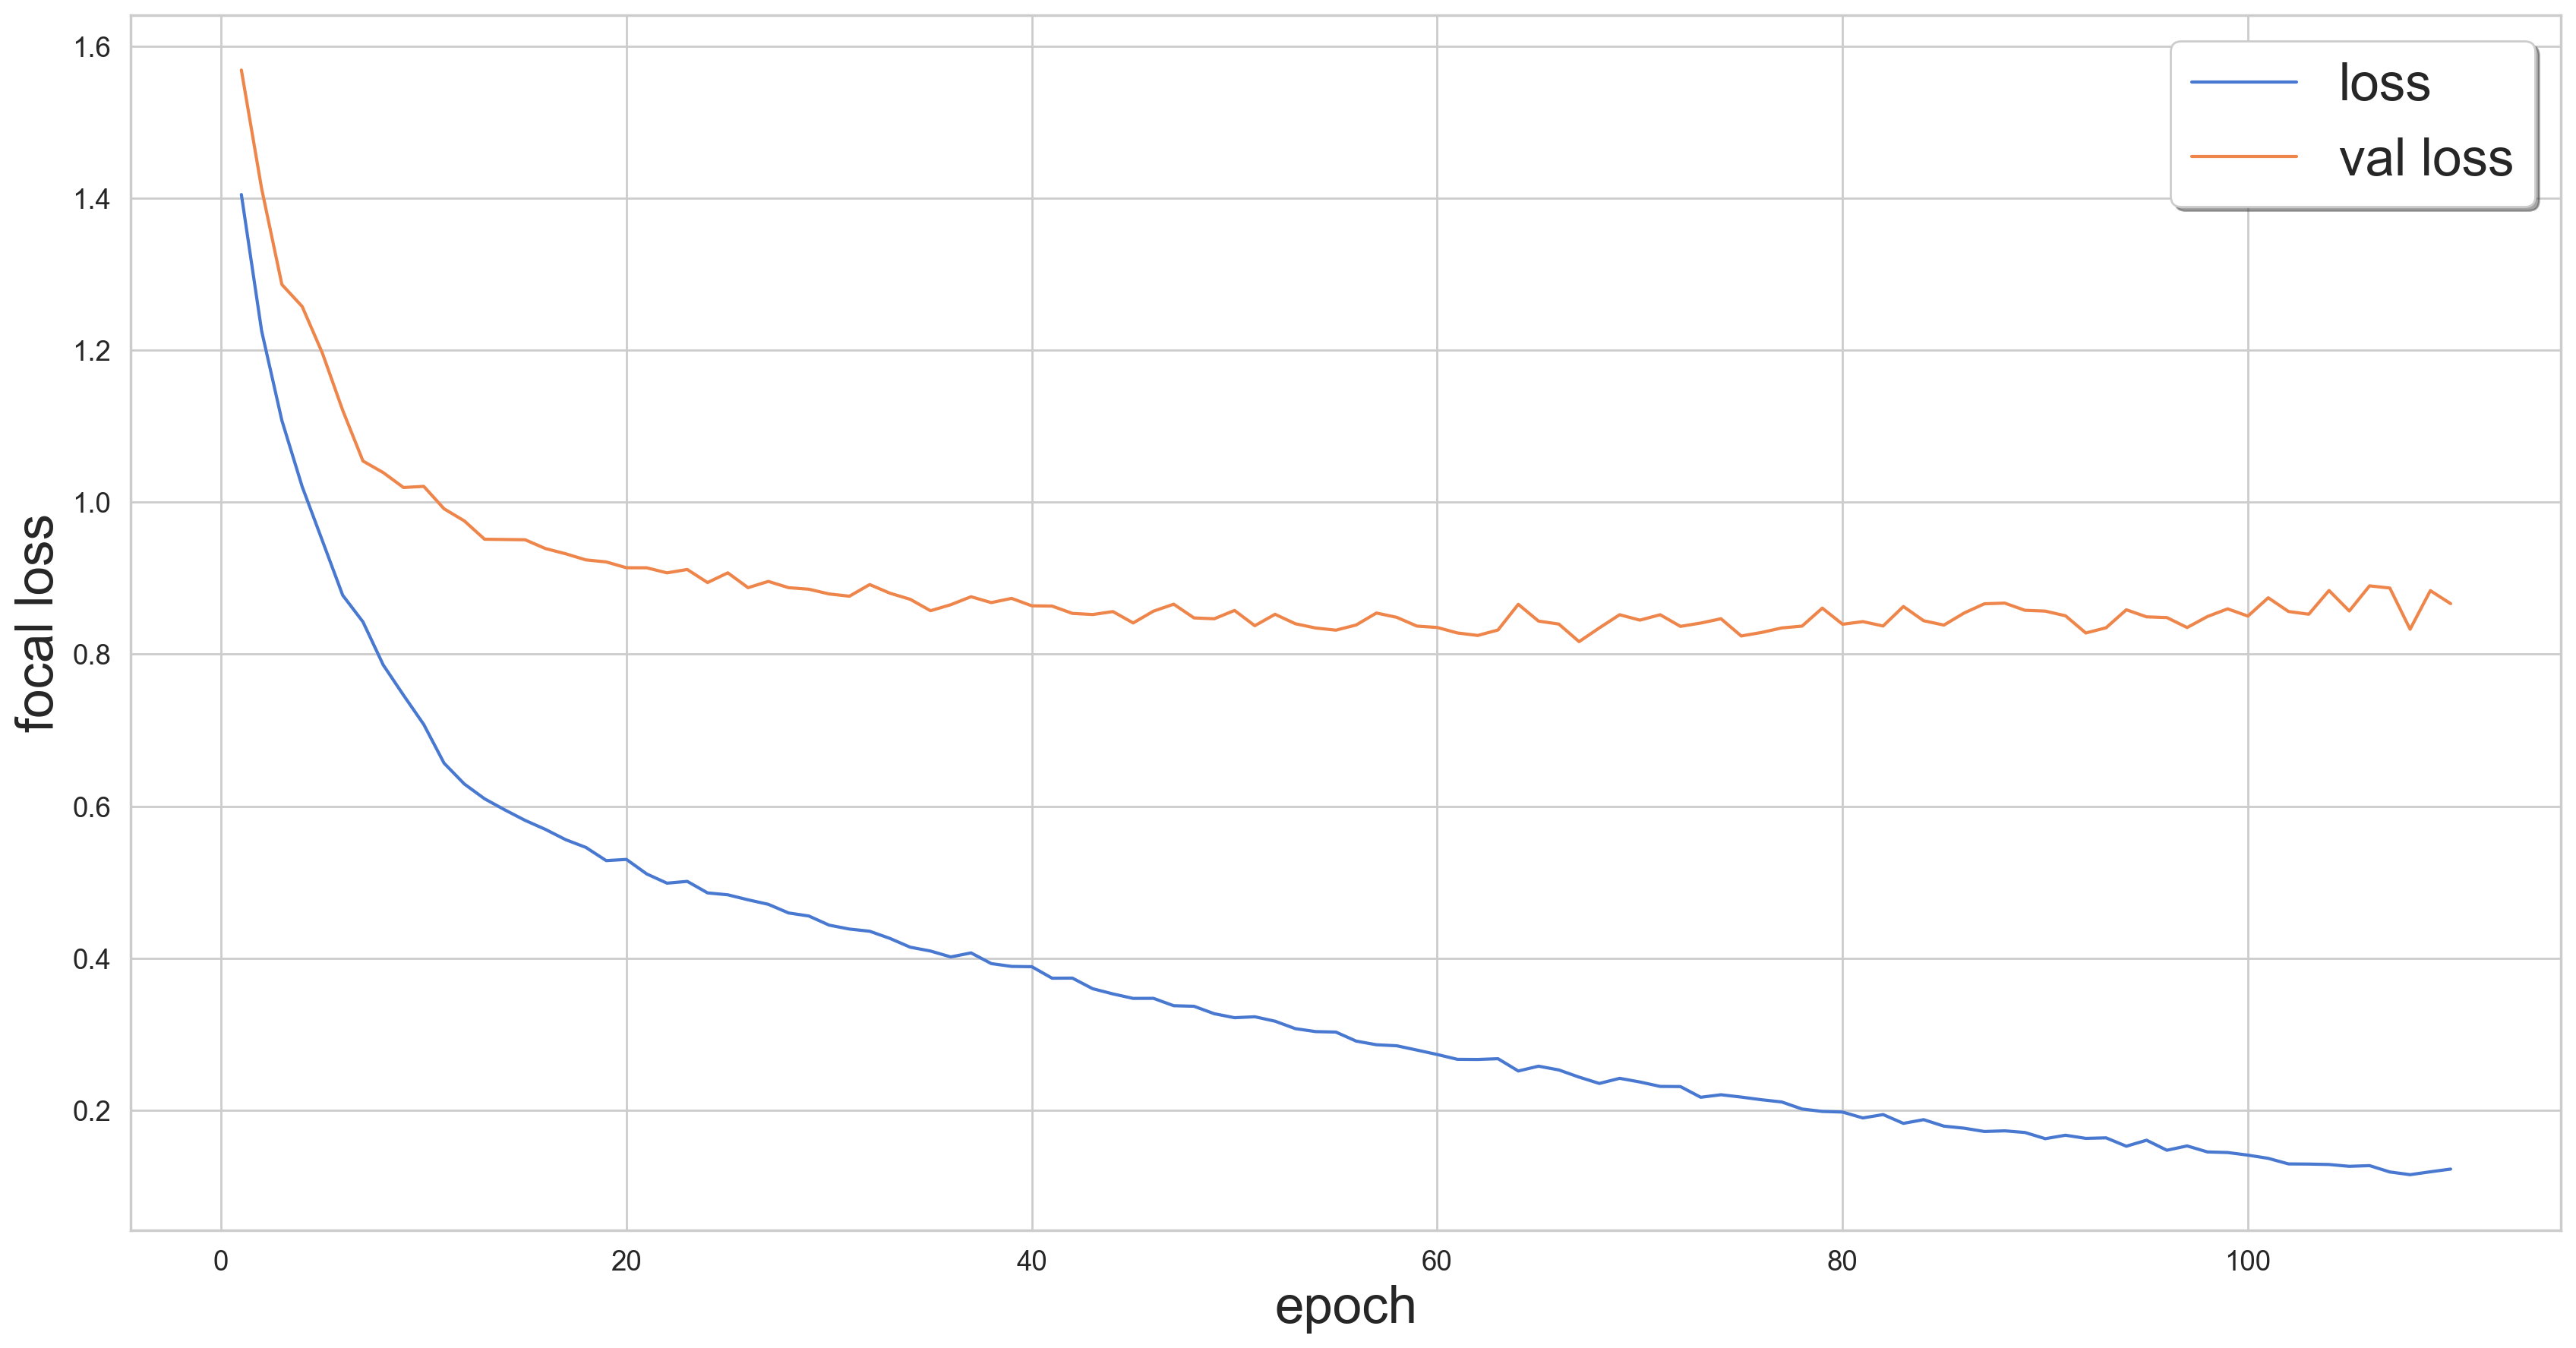

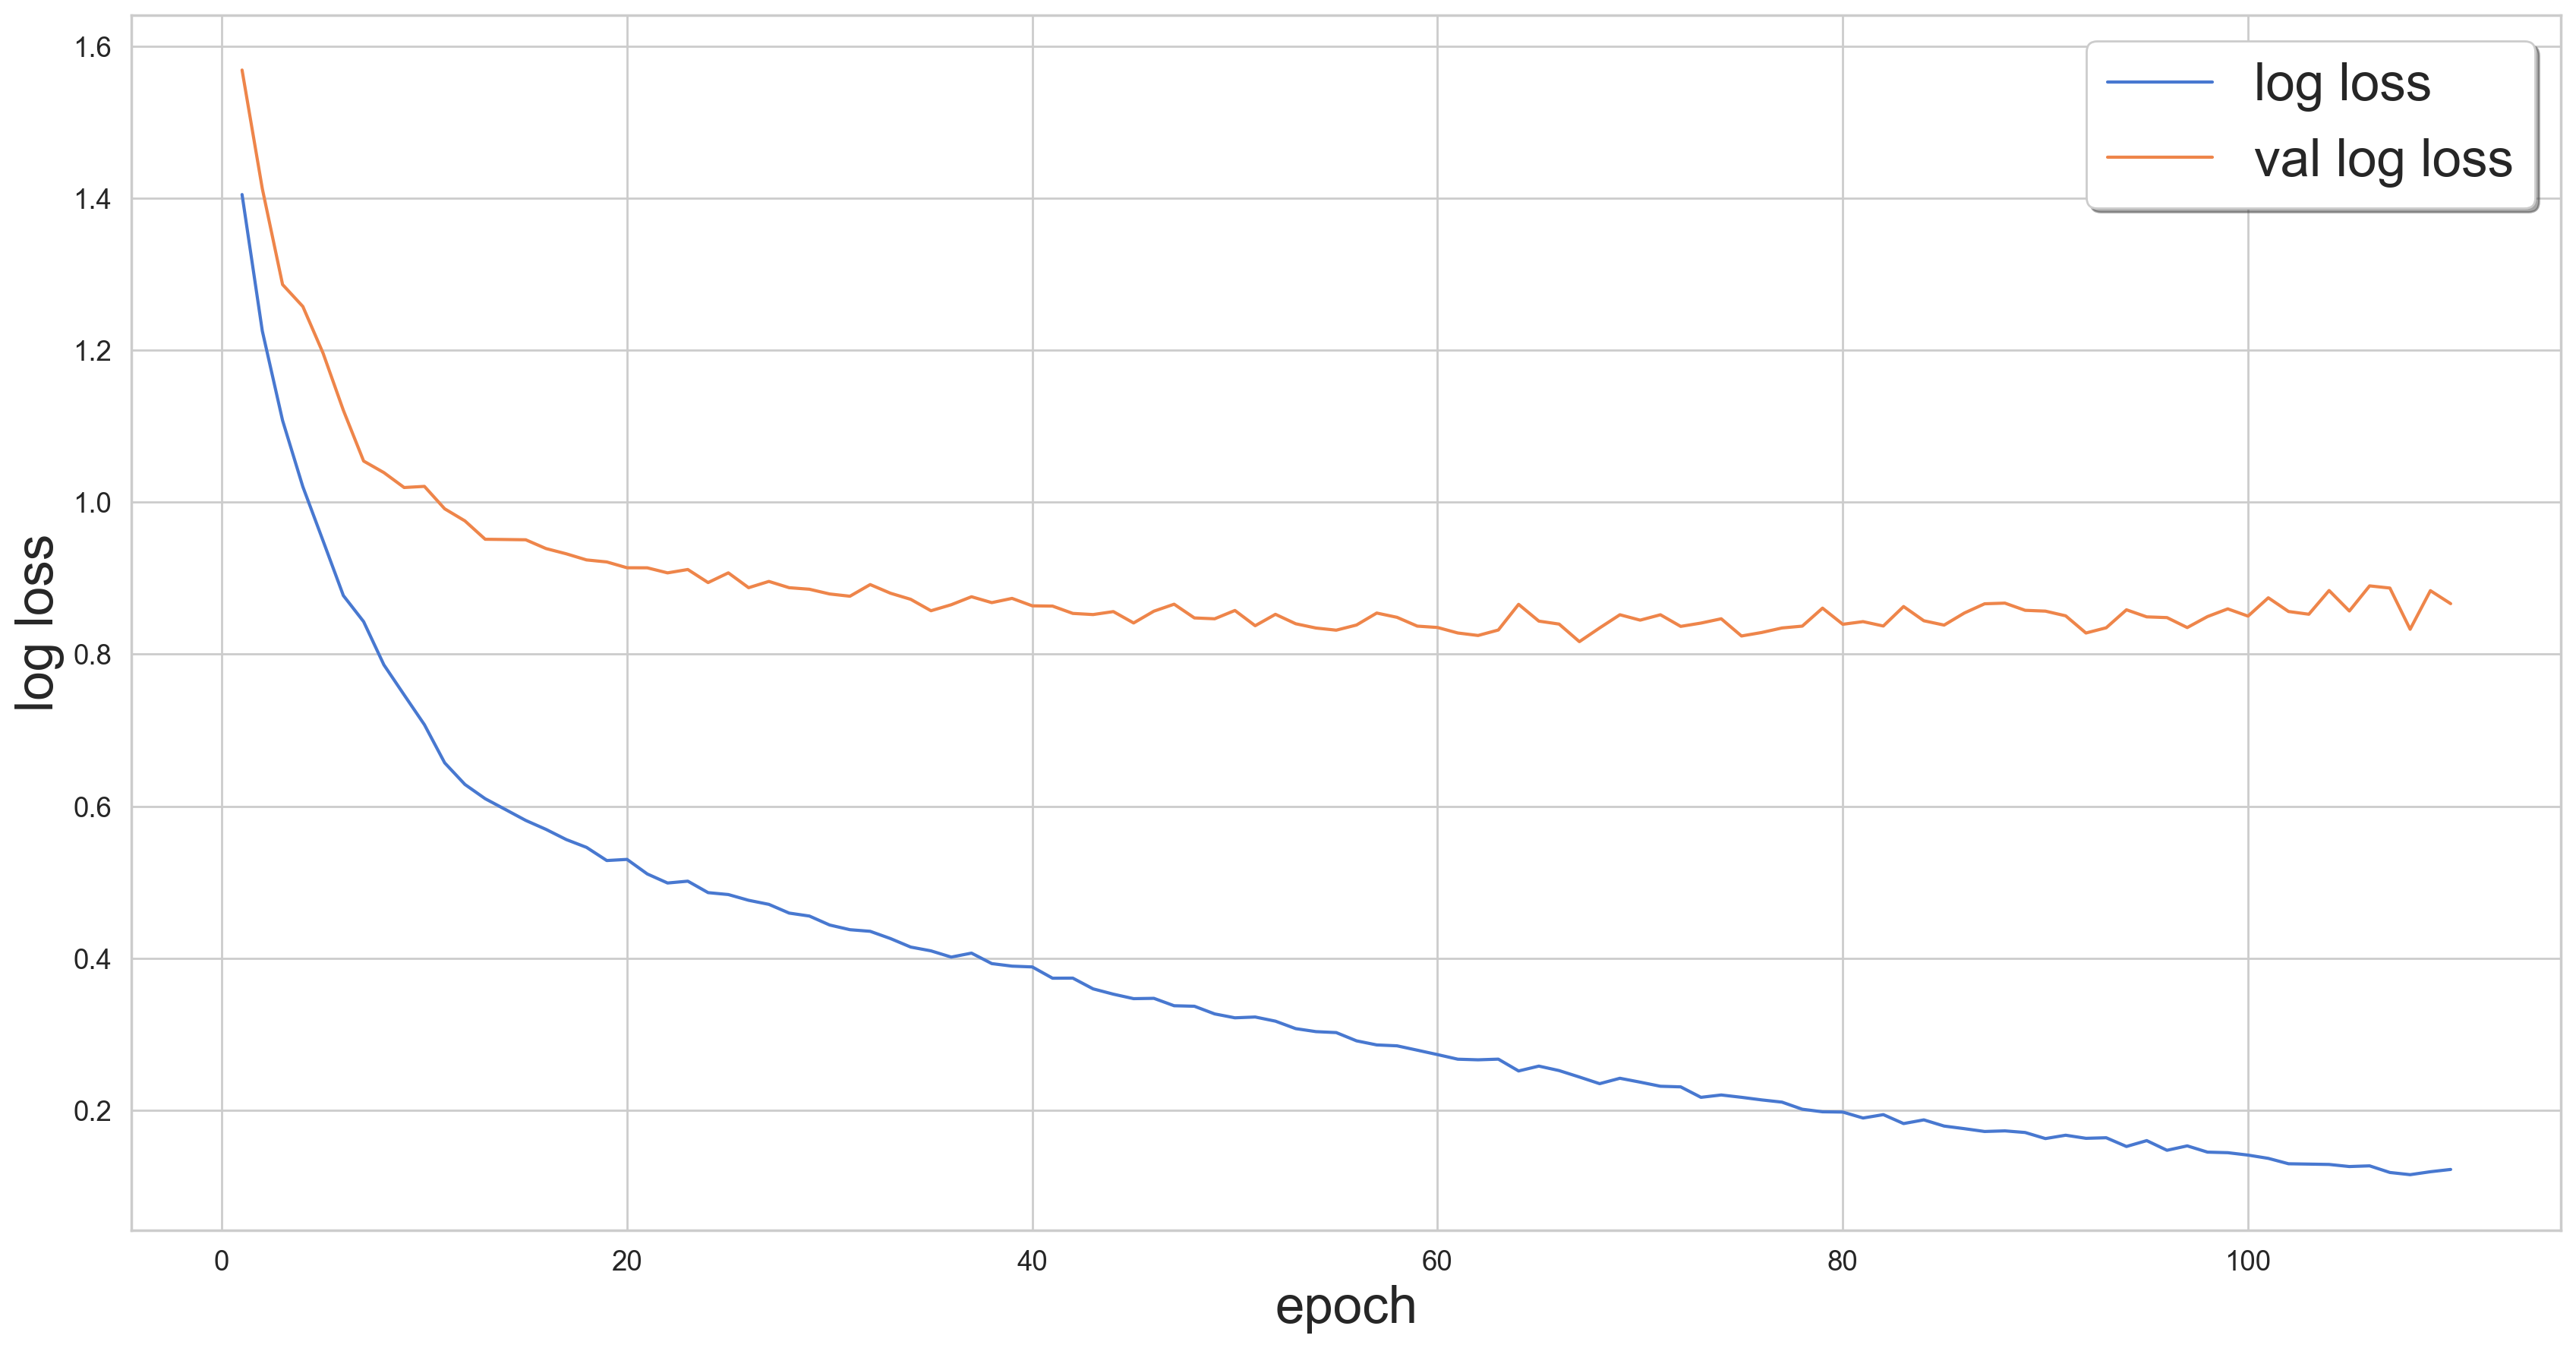

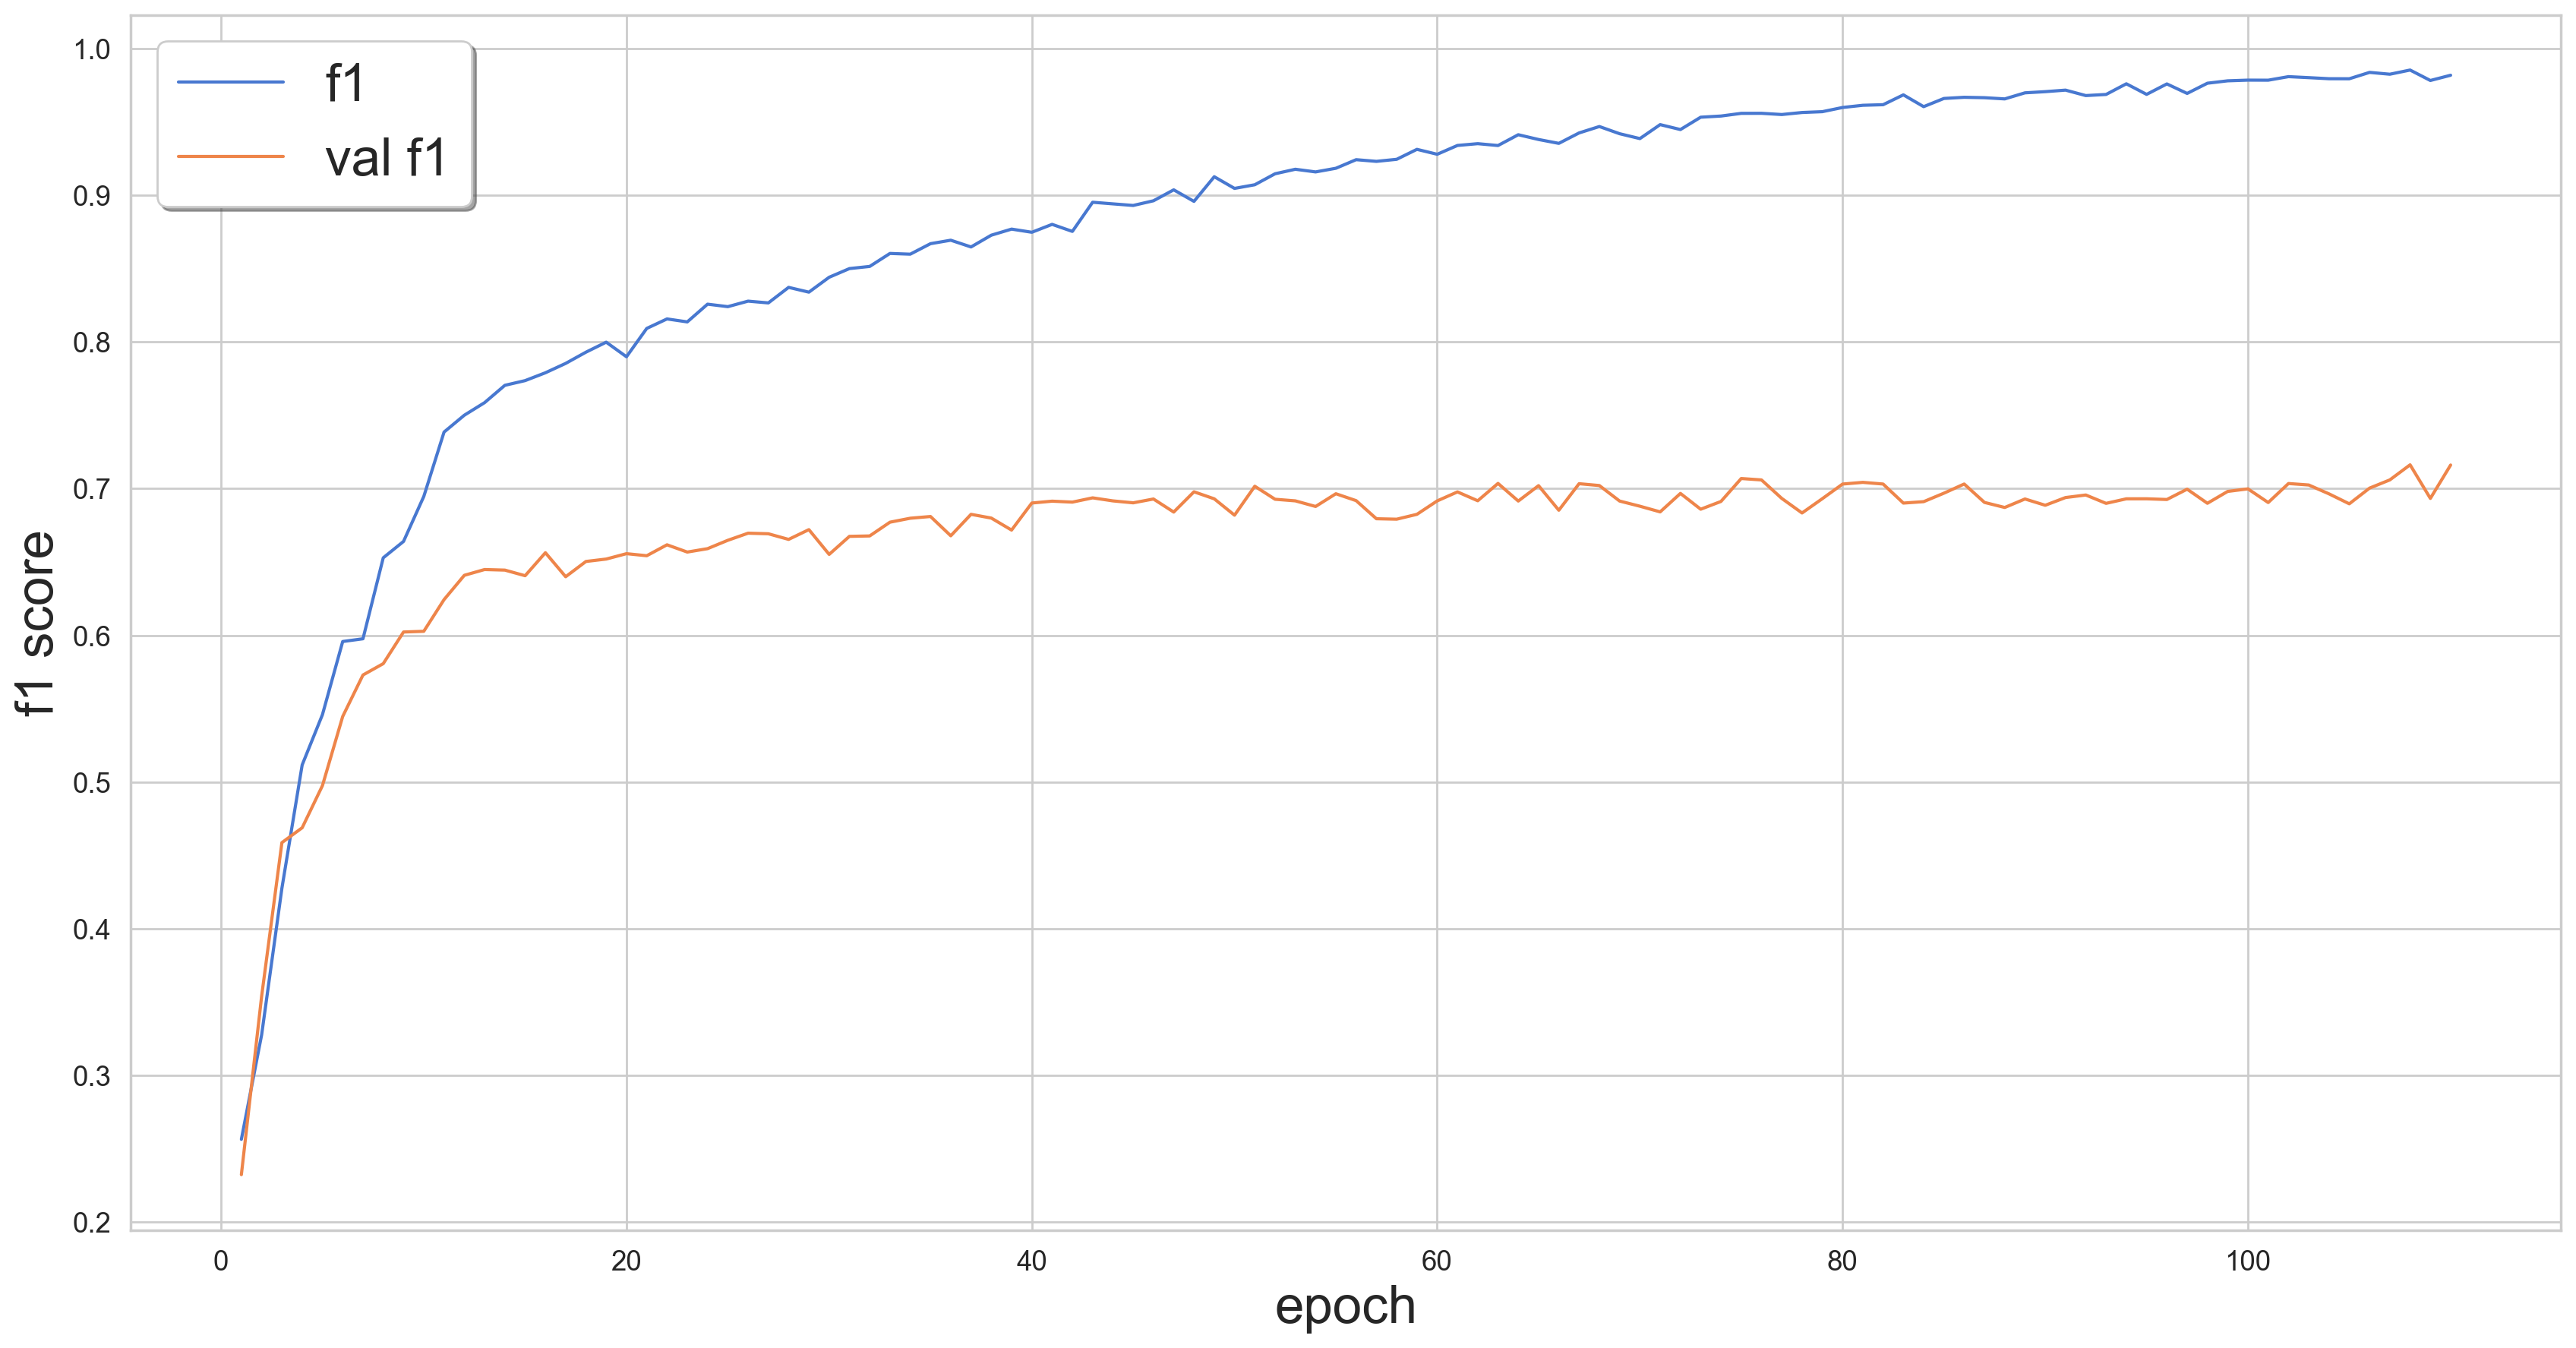

In [26]:
trainer.visualize_results()

In [6]:
load_path= save_dir / "resnet18" / "resnet18.pth"

```Res18_config``` |  ```ENb0_config``` | ```MNv2_config``` | ```ENv2_config```

In [9]:
loaded_model= TrafficClassifier(load_path= load_path, cfg=Res18_config)

[*] Attempting to load model from: d:\Work\Extra\myanmar-weather-forecasting\src\traffic\models\models_runs\resnet18\resnet18.pth
[*] Initializing new resnet18 network...


c:\Users\AmrEl\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AmrEl\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
_, f1, _= loaded_model.test_model(test_dataloader)

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_16860\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


In [26]:
f1

0.7174680422963312

In [27]:
test_img= root_dir/"test"/"Low"/"6ae37c12-477a-4c52-9913-273d444db4a3.jpg"

In [28]:
# str for windows to work with cv2
loaded_model.inference(str(test_img))

'Low'

`Resnet18` F1: 0.7174680422963312 , 135 MB

`ENb0` F1: 0.605237066371112  , 47.1 MB

`MNv2` F1: 0.6470038020228335  , 26.6 MB

`ENv2-S` F1: 0.4708560014866464 , 232 MB